# Natural Language Processing

&copy; 李浩东 3190104890@zju.edu.cn

- Word Embedding (word2vec)
- Word Embedding with Global Vectors (GloVe)
- Subword Embedding
- Bidirectional Encoder Representations from Transformers (BERT)
- Pretraining BERT

---

- Sentiment Analysis: Using RNN & CNN
- Natural Language Inference: Fine-Tuning BERT
- Chat with ChatGPT
- nanoGPT: The simplest, fastest repository for training/finetuning medium-sized GPTs

![gpt-4-motif.svg](./images/8/GPT-4-cover.png)


## Word Embedding (word2vec)

### One-Hot Vectors Are a Bad Choice

- Although one-hot word vectors are easy to construct, they are usually not a good choice.
- A main reason is that one-hot word vectors cannot accurately express the similarity between different words, such as the *cosine similarity* that we often use. 
- For vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarity is the cosine of the angle between them:


$$\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].$$


- Since the cosine similarity between one-hot vectors of any two different words is 0, one-hot vectors cannot encode similarities among words.


### Self-Supervised word2vec

- The [word2vec](https://code.google.com/archive/p/word2vec/) tool was proposed to address the above issue.
- It maps each word to a fixed-length vector, and  these vectors can better express the similarity and analogy relationship among different words.
    - skip-gram
    - ontinuous bag of words (CBOW)

### The Skip-Gram Model

![skip-gram.svg](./images/8/skip-gram.svg)

- The *skip-gram* model assumes that a word can be used to generate its surrounding words in a text sequence.
- Take the text sequence "the", "man", "loves", "his", "son" as an example.
- Let's choose "loves" as the *center word* and set the context window size to 2. given the center word "loves", the skip-gram model considers the conditional probability for generating the *context words*: "the", "man", "his", and "son", which are no more than 2 words away from the center word:

$$P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).$$

- Assume that the context words are independently generated given the center word (i.e., conditional independence). In this case, the above conditional probability can be rewritten as

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$


- In the skip-gram model, each word has two $d$-dimensional-vector representations for calculating conditional probabilities.
- More concretely, for any word with index $i$ in the dictionary, denote by $\mathbf{v}_i\in\mathbb{R}^d$ and $\mathbf{u}_i\in\mathbb{R}^d$ its two vectors when used as a *center* word and a *context* word, respectively. The conditional probability of generating any context word $w_o$ (with index $o$ in the dictionary) given the center word $w_c$ (with index $c$ in the dictionary) can be modeled by a softmax operation on vector dot products:


$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$

- where the vocabulary index set $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$.
- Given a text sequence of length $T$, where the word at time step $t$ is denoted as $w^{(t)}$. Assume that context words are independently generated given any center word. 
- For context window size $m$, the likelihood function of the skip-gram model is the probability of generating all context words given any center word:


$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

- where any time step that is less than $1$ or greater than $T$ can be omitted.

#### Training

- The skip-gram model parameters are the center word vector and context word vector for each word in the vocabulary.
- In training, we learn the model parameters by maximizing the likelihood function (i.e., maximum likelihood estimation). This is equivalent to minimizing the following loss function:

$$ - \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \text{log}\, P(w^{(t+j)} \mid w^{(t)}).$$

- When using stochastic gradient descent to minimize the loss, in each iteration we can randomly sample a shorter subsequence to calculate the (stochastic) gradient for this subsequence to update the model parameters.
- To calculate this (stochastic) gradient, we need to obtain the gradients of the log conditional probability with respect to the center word vector and the context word vector.

- The log conditional probability involving any pair of the center word $w_c$ and the context word $w_o$ is


$$\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$

- Through differentiation, we can obtain its gradient with respect to the center word vector $\mathbf{v}_c$ as

$$\begin{aligned}\frac{\partial \text{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.\end{aligned}$$

- The gradients for the other word vectors can be obtained in the same way.
- After training, for any word with index $i$ in the dictionary, we obtain both word vectors $\mathbf{v}_i$ (as the center word) and $\mathbf{u}_i$ (as the context word).


### The Continuous Bag of Words (CBOW) Model

![cbow.svg](./images/8/cbow.svg)

- The *continuous bag of words* (CBOW) model is similar to the skip-gram model. The major difference from the skip-gram model is that the continuous bag of words model assumes that a center word is generated based on its surrounding context words in the text sequence.

$$P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).$$


- Since there are multiple context words in the continuous bag of words model, these context word vectors are averaged in the calculation of the conditional probability.
- Specifically, for any word with index $i$ in the dictionary, denote by $\mathbf{v}_i\in\mathbb{R}^d$ and $\mathbf{u}_i\in\mathbb{R}^d$ its two vectors when used as a *context* word and a *center* word (meanings are switched in the skip-gram model), respectively.
- The conditional probability of generating any center word $w_c$ (with index $c$ in the dictionary) given its surrounding context words $w_{o_1}, \ldots, w_{o_{2m}}$ (with index $o_1, \ldots, o_{2m}$ in the dictionary) can be modeled by

$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \text{exp}\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.$$

- For brevity, let $\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$ and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}} \right)/(2m)$. Then it can be simplified as

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

- Given a text sequence of length $T$, where the word at time step $t$ is denoted as $w^{(t)}$.
- For context window size $m$, the likelihood function of the continuous bag of words model is the probability of generating all center words given their context words:

$$ \prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

#### Training

- Training continuous bag of words models is almost the same as training skip-gram models. The maximum likelihood estimation of the continuous bag of words model is equivalent to minimizing the following loss function:



$$  -\sum_{t=1}^T  \text{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

- Notice that

$$\log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).$$

- Through differentiation, we can obtain its gradient with respect to any context word vector $\mathbf{v}_{o_i}$($i = 1, \ldots, 2m$) as


$$\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) = \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).$$

- The gradients for the other word vectors can be obtained in the same way. Unlike the skip-gram model, the continuous bag of words model typically uses context word vectors as the word representations.

## Approximate Training

- The main idea of the skip-gram model is using softmax operations to calculate the conditional probability of generating a context word $w_o$ based on the given center word $w_c$.
- Due to the nature of the softmax operation, since a context word may be anyone in the dictionary $\mathcal{V}$, the opposite of corresponding logarithmic loss contains the summation of items as many as the entire size of the vocabulary.
- Unfortunately, the computational cost for such gradients that sum over a large dictionary (often with hundreds of thousands or millions of words) is huge!
- In order to reduce the aforementioned computational complexity, this section will introduce two approximate training methods: *negative sampling* and *hierarchical softmax*.

### Negative Sampling

- Negative sampling modifies the original objective function. Given the context window of a center word $w_c$, the fact that any (context) word $w_o$ comes from this context window is considered as an event with the probability modeled by


$$P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c),$$

- where $\sigma$ uses the definition of the sigmoid activation function:

$$\sigma(x) = \frac{1}{1+\exp(-x)}.$$

- Let's begin by maximizing the joint probability of all such events in text sequences to train word embeddings. Specifically, given a text sequence of length $T$, denote by $w^{(t)}$ the word at time step $t$ and let the context window size be $m$, consider maximizing the joint probability


$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).$$


$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).$$

- The joint probability in is maximized to 1 only if all the word vectors are equal to infinity.
- Of course, such results are meaningless. To make the objective function more meaningful, *negative sampling* adds negative examples sampled from a predefined distribution.
- Denote by $S$ the event that a context word $w_o$ comes from the context window of a center word $w_c$. For this event involving $w_o$, from a predefined distribution $P(w)$ sample $K$ *noise words* that are not from this context window.
- Denote by $N_k$ the event that a noise word $w_k$ ($k=1, \ldots, K$) does not come from the context window of $w_c$. Assume that these events involving both the positive example and negative examples $S, N_1, \ldots, N_K$ are mutually independent. Negative sampling rewrites the joint probability (involving only positive examples) as

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

- where the conditional probability is approximated through events $S, N_1, \ldots, N_K$:

$$ P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).$$

- Denote by $i_t$ and $h_k$ the indices of a word $w^{(t)}$ at time step $t$ of a text sequence and a noise word $w_k$, respectively. The logarithmic loss with respect to the conditional probabilities is

$$
\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}
$$

- We can see that now the computational cost for gradients at each training step has nothing to do with the dictionary size, but linearly depends on $K$. When setting the hyperparameter $K$ to a smaller value, the computational cost for gradients at each training step with negative sampling is smaller.

#### Discussion

You: What is negative sampling, for approximating the Word Embedding (word2vec) calculation?

---

ChatGPT: Negative sampling is a method for approximating the calculation of Word Embedding, specifically in the case of the popular word2vec algorithm. It aims to address the high computational cost associated with the original version of the algorithm, which requires computing the softmax function for each word in the vocabulary. 

In negative sampling, instead of considering all words in the vocabulary, **a small number (typically 5-20)** of "negative" words are sampled at random for each training example. These negative words are assumed to not appear in the context of the target word, and their embeddings are adjusted so as to minimize the likelihood of them appearing in the context. This is done in addition to optimizing the embeddings of the actual "positive" context words. 

By using negative sampling, the computational complexity of the word2vec algorithm is greatly reduced, while still producing word embeddings that capture meaningful semantic relationships between words.

---

You: Then the conditional probabilities of generating all the words in dictionary V is not equal to 1, is that sensible?

---

ChatGPT: When using negative sampling for word embedding approximations, **the conditional probabilities of generating all the words in the dictionary V may not sum to exactly 1**. This is because negative sampling only considers a subset of the vocabulary as "negative" samples, and the probabilities of these negative samples are adjusted to minimize the likelihood that they appear in the context. Therefore, the original true probabilities of generating these "negative" words may not be preserved in the final model.

However, this does not necessarily mean that the model is not sensible or effective. Negative sampling is a common technique used in word embedding algorithms, and it has been shown to produce high-quality word embeddings that capture meaningful semantic relationships between words. The slight deviation from a probabilistic interpretation can be seen as an approximation that still yields desirable results with reduced computational complexity.


### Hierarchical Softmax

- As an alternative approximate training method, *hierarchical softmax* uses the binary tree, a data structure illustrated below, where each leaf node of the tree represents a word in dictionary $\mathcal{V}$.

![hi-softmax.svg](./images/8/hi-softmax.svg)


- Denote by $L(w)$ the number of nodes (including both ends) on the path from the root node to the leaf node representing word $w$ in the binary tree.
- Let $n(w,j)$ be the $j^\mathrm{th}$ node on this path, with its context word vector being $\mathbf{u}_{n(w, j)}$. For example, $L(w_3) = 4$.
- Hierarchical softmax approximates the conditional probability as

$$P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \text{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right),$$

- where $\text{leftChild}(n)$ is the left child node of node $n$: if $x$ is true, $[\![x]\!] = 1$; otherwise $[\![x]\!] = -1$.


- To illustrate, let's calculate the conditional probability of generating word $w_3$ given word $w_c$ in :numref:`fig_hi_softmax`. This requires dot products between the word vector $\mathbf{v}_c$ of $w_c$ and non-leaf node vectors on the path from the root to $w_3$, which is traversed left, right, then left:


$$P(w_3 \mid w_c) = \sigma(\mathbf{u}_{n(w_3, 1)}^\top \mathbf{v}_c) \cdot \sigma(-\mathbf{u}_{n(w_3, 2)}^\top \mathbf{v}_c) \cdot \sigma(\mathbf{u}_{n(w_3, 3)}^\top \mathbf{v}_c).$$

- Since $\sigma(x)+\sigma(-x) = 1$, it holds that the conditional probabilities of generating all the words in dictionary $\mathcal{V}$ based on any word $w_c$ sum up to one: 

$$\sum_{w \in \mathcal{V}} P(w \mid w_c) = 1.$$

- Fortunately, since $L(w_o)-1$ is on the order of $\mathcal{O}(\text{log}_2|\mathcal{V}|)$ due to the binary tree structure, when the dictionary size $\mathcal{V}$ is huge, the computational cost for  each training step using hierarchical softmax is significantly reduced compared with that without approximate training.

## The Dataset for Pretraining Word Embeddings

- Now that we know the technical details of the word2vec models and approximate training methods, let’s walk through their implementations.
- In this section, we begin with the dataset for pretraining the word embedding model: the original format of the data will be transformed into minibatches that can be iterated over during training.


In [1]:
import collections
import math
import os
import random
import torch
from torch import nn
from d2l import torch as d2l

- The dataset that we use here is [Penn Tree Bank (PTB)]( https://catalog.ldc.upenn.edu/LDC99T42). This corpus is sampled from Wall Street Journal articles, split into training, validation, and test sets.
- In the original format, each line of the text file represents a sentence of words that are separated by spaces.
- Here we treat each word as a token.


In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

- After reading the training set, we build a vocabulary for the corpus, where any word that appears less than 10 times is replaced by the “\<unk\>” token. Note that the original dataset also contains “\<unk\>” tokens that represent rare (unknown) words.

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

### Subsampling

- Text data typically have high-frequency words such as “the”, “a”, and “in”: they may even occur billions of times in very large corpora. However, these words often co-occur with many different words in context windows, providing little useful signals. 
- For instance, consider the word “chip” in a context window: intuitively its co-occurrence with a low-frequency word “intel” is more useful in training than the co-occurrence with a high-frequency word “a”. Moreover, training with vast amounts of (high-frequency) words is slow. Thus, when training word embedding models, high-frequency words can be subsampled (Mikolov et al., 2013).
- Specifically, each indexed word $w_i$ in the dataset will be discarded with probability


$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

- where $f(w_i)$ is the ratio of the number of words $w_i$ to the total number of words in the dataset, and the constant $t$ is a hyperparameter ($10^{-4}$ in the experiment). We can see that only when the relative frequency $f(w_i) > t$  can the (high-frequency) word $w_i$ be discarded,  and the higher the relative frequency of the word,  the greater the probability of being discarded.


In [4]:
#@save
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

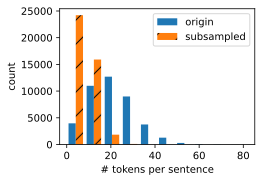

In [5]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled)

In [6]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2052'

In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [3228, 710, 4060], [3922, 1922, 4743]]

### Extracting Center Words and Context Words

- It uniformly samples an integer between 1 and `max_window_size` at random as the context window size.


In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


- When training on the PTB dataset, we set the maximum context window size to 5. The following extracts all the center words and their context words in the dataset.

In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1502675'

### Negative Sampling

- We use negative sampling for approximate training. To sample noise words according to a predefined distribution, we define the following `RandomGenerator` class, where the (possibly unnormalized) sampling distribution is passed via the argument `sampling_weights`.

In [12]:
#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [13]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 2, 1, 1, 2, 3, 3, 3, 3, 2]

- For a pair of center word and context word, we randomly sample `K` (5 in the experiment) noise words. According to the suggestions in the word2vec paper, the sampling probability $P(w)$ of a noise word $w$ is set to its relative frequency in the dictionary raised to the power of 0.75.

In [14]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

### Loading Training Examples in Minibatches

- In a minibatch, the $i^\mathrm{th}$ example includes a center word and its $n_i$ context words and $m_i$ noise words.  Due to varying context window sizes, $n_i+m_i$ varies for different $i$. Thus, for each example we concatenate its context words and noise words in  the `contexts_negatives` variable, and pad zeros until the concatenation length reaches $\max_i n_i+m_i$ (`max_len`). To exclude paddings in the calculation of the loss, we define a mask variable `masks`. There is a one-to-one correspondence between elements in `masks` and elements in `contexts_negatives`, where zeros (otherwise ones) in `masks` correspond to paddings in `contexts_negatives`.

- To distinguish between positive and negative examples, we separate context words from noise words in  `contexts_negatives` via a `labels` variable, similar to `masks`.


In [15]:
#@save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [16]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


### Putting It All Together

In [17]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

In [18]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


## Pretraining word2vec

In [19]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

### The Skip-Gram Model

- We implement the skip-gram model by using embedding layers and batch matrix multiplications.

In [20]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


- The input of an embedding layer is the index of a token (word).
- For any token index $i$, its vector representation can be obtained from the $i^\mathrm{th}$ row of the weight matrix in the embedding layer.

In [21]:
x = torch.tensor([[1, 2, 3], [3, 4, 5]])
embed(x)

tensor([[[-1.2976, -0.1158, -0.3598, -0.6239],
         [-0.6515, -1.2558,  0.9660,  0.7976],
         [ 0.8370,  1.6535, -0.7562, -0.0753]],

        [[ 0.8370,  1.6535, -0.7562, -0.0753],
         [-1.1562, -1.2339,  1.1942,  0.2774],
         [-0.1997,  0.9390,  1.0504,  0.5765]]], grad_fn=<EmbeddingBackward0>)

#### Defining the Forward Propagation

- In the forward propagation, the input of the skip-gram model includes the center word indices `center` of shape (batch size, 1) and the concatenated context and noise word indices `contexts_and_negatives` of shape (batch size, `max_len`).
- These two variables are first transformed from the token indices into vectors via the embedding layer, then their batch matrix multiplication returns an output of shape (batch size, 1, `max_len`).
- Each element in the output is the dot product of a center word vector and a context or noise word vector.


- Another commonly used operation is to multiply batches of matrices with another. This comes in handy when we have minibatches of queries, keys, and values. More specifically, assume that 

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b} \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c} 
$$

- Then the batch matrix multiplication (BMM) computes the element-wise product

$$\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [23]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

### Training

#### Binary Cross-Entropy Loss

In [24]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [25]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [26]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


#### Initializing Model Parameters

- We define two embedding layers for all the words in the vocabulary when they are used as center words and context words, respectively. The word vector dimension `embed_size` is set to 100.

In [27]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

#### The Training Loop

In [28]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.366, 1616602.2 tokens/sec on cuda:0


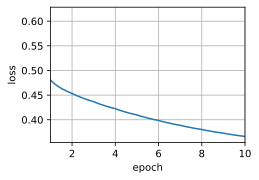

In [29]:
lr, num_epochs = 0.002, 10
train(net, data_iter, lr, num_epochs)

### Applying Word Embeddings

- After training the word2vec model, we can use the cosine similarity of word vectors from the trained model to find words from the dictionary that are most semantically similar to an input word.

In [30]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.666: intel
cosine sim=0.655: microprocessor
cosine sim=0.579: chips


## Word Embedding with Global Vectors (GloVe)

- Word-word co-occurrences within context windows may carry rich semantic information. For example, in a large corpus word "solid" is more likely to co-occur with "ice" than "steam", but word "gas" probably co-occurs with "steam" more frequently than "ice". 
- Besides, **global corpus statistics of such co-occurrences can be precomputed: this can lead to more efficient training**. To leverage statistical information in the entire corpus for word embedding, let's first revisit the skip-gram model, but interpreting it using global corpus statistics such as co-occurrence counts.


### Skip-Gram with Global Corpus Statistics

- Denoting by $q_{ij}$ the conditional probability $P(w_j\mid w_i)$ of word $w_j$ given word $w_i$ in the skip-gram model, we have

$$q_{ij}=\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_i)}{ \sum_{k \in \mathcal{V}} \text{exp}(\mathbf{u}_k^\top \mathbf{v}_i)},$$

- where for any index $i$ vectors $\mathbf{v}_i$ and $\mathbf{u}_i$ represent word $w_i$ as the center word and context word, respectively, and $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$ is the index set of the vocabulary.
- Consider word $w_i$ that may occur multiple times in the corpus. In the entire corpus, all the context words wherever $w_i$ is taken as their center word form a *multiset* $\mathcal{C}_i$ of word indices that *allows for multiple instances of the same element*. For any element, its number of instances is called its *multiplicity*.
- To illustrate with an example, suppose that word $w_i$ occurs twice in the corpus and indices of the context words that take $w_i$ as their center word in the two context windows are $k, j, m, k$ and $k, l, k, j$. Thus, multiset $\mathcal{C}_i = \{j, j, k, k, k, k, l, m\}$, where multiplicities of elements $j, k, l, m$ are 2, 4, 1, 1, respectively.

- Now let's denote the multiplicity of element $j$ in multiset $\mathcal{C}_i$ as $x_{ij}$. This is the global co-occurrence count of word $w_j$ (as the context word) and word $w_i$ (as the center word) in the same context window in the entire corpus. 
- Using such global corpus statistics, the loss function of the skip-gram model is equivalent to

$$-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij}.$$

- We further denote by $x_i$ the number of all the context words in the context windows where $w_i$ occurs as their center word, which is equivalent to $|\mathcal{C}_i|$. Letting $p_{ij}$ be the conditional probability $x_{ij}/x_i$ for generating context word $w_j$ given center word $w_i$, the loss function can be rewritten as

$$-\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.$$

$$-\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.$$

- $-\sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}$ calculates the cross-entropy of the conditional distribution $p_{ij}$ of global corpus statistics and the conditional distribution $q_{ij}$ of model predictions. This loss is also weighted by $x_i$ as explained above. Minimizing the loss function will allow the predicted conditional distribution to get close to the conditional distribution from the global corpus statistics.
- Though being commonly used for measuring the distance between probability distributions, the cross-entropy loss function may not be a good choice here.
    - On the one hand, the cost of properly normalizing $q_{ij}$ results in the sum over the entire vocabulary, which can be computationally expensive. 
    - On the other hand, a large number of rare events from a large corpus are often modeled by the cross-entropy loss to be assigned with too much weight.

### The GloVe Model

- In view of this, the *GloVe* model makes three changes to the skip-gram model based on squared loss.
    - Use variables $p'_{ij}=x_{ij}$ and $q'_{ij}=\exp(\mathbf{u}_j^\top \mathbf{v}_i)$
    that are not probability distributions
    and take the logarithm of both, so the squared loss term is $\left(\log\,p'_{ij} - \log\,q'_{ij}\right)^2 = \left(\mathbf{u}_j^\top \mathbf{v}_i - \log\,x_{ij}\right)^2$.
    - Add two scalar model parameters for each word $w_i$: the center word bias $b_i$ and the context word bias $c_i$.
    - Replace the weight of each loss term with the weight function $h(x_{ij})$, where $h(x)$ is increasing in the interval of $[0, 1]$.
- Putting all things together, training GloVe is to minimize the following loss function:

$$\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.$$


- For the weight function, a suggested choice is: $h(x) = (x/c) ^\alpha$ (e.g $\alpha = 0.75$) if $x < c$ (e.g., $c = 100$); otherwise $h(x) = 1$.
- In this case, because $h(0)=0$, the squared loss term for any $x_{ij}=0$ can be omitted for computational efficiency. For example, when using minibatch stochastic gradient descent for training, at each iteration we randomly sample a minibatch of *non-zero* $x_{ij}$ to calculate gradients and update the model parameters.
- Note that these non-zero $x_{ij}$ are precomputed global corpus statistics; thus, the model is called GloVe for *Global Vectors*.
- It should be emphasized that if word $w_i$ appears in the context window of word $w_j$, then *vice versa*. Therefore, $x_{ij}=x_{ji}$. Unlike word2vec that fits the asymmetric conditional probability $p_{ij}$, GloVe fits the symmetric $\log \, x_{ij}$. Therefore, the center word vector and the context word vector of any word are mathematically equivalent in the GloVe model.
- However in practice, owing to different initialization values, the same word may still get different values in these two vectors after training: GloVe sums them up as the output vector.



### Interpreting GloVe from the Ratio of Co-occurrence Probabilities


- We can also interpret the GloVe model from another perspective.
- Let $p_{ij} \stackrel{\mathrm{def}}{=} P(w_j \mid w_i)$ be the conditional probability of generating the context word $w_j$ given $w_i$ as the center word in the corpus.

|$$w_k=$$|solid|gas|water|fashion|
|:-----------------|:-|:-|:-|:-|
|$$p_1=P(w_k\mid \text{ice})$$|0.00019|0.000066|0.003|0.000017|
|$$p_2=P(w_k\mid\text{steam})$$|0.000022|0.00078|0.0022|0.000018|
|$$p_1/p_2$$|8.9|0.085|1.36|0.96|

- For a word $w_k$ that is related to "ice" but unrelated to "steam", such as $w_k=\text{solid}$, we expect a larger ratio of co-occurence probabilities, such as 8.9.
- For a word $w_k$ that is related to "steam" but unrelated to "ice", such as $w_k=\text{gas}$, we expect a smaller ratio of co-occurence probabilities, such as 0.085.
- For a word $w_k$ that is related to both "ice" and "steam", such as $w_k=\text{water}$, we expect a ratio of co-occurence probabilities that is close to 1, such as 1.36.
- For a word $w_k$ that is unrelated to both "ice" and "steam", such as $w_k=\text{fashion}$, we expect a ratio of co-occurence probabilities that is close to 1, such as 0.96.


- It can be seen that the ratio of co-occurrence probabilities can intuitively express the relationship between words. Thus, we can design a function of three word vectors to fit this ratio. 
- For the ratio of co-occurrence probabilities ${p_{ij}}/{p_{ik}}$ with $w_i$ being the center word and $w_j$ and $w_k$ being the context words,
we want to fit this ratio using some function $f$:

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.$$


- Among many possible designs for $f$, we only pick a reasonable choice in the following. Since the ratio of co-occurrence probabilities is a scalar, e require that $f$ be a scalar function, such as $f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = f\left((\mathbf{u}_j - \mathbf{u}_k)^\top {\mathbf{v}}_i\right)$.
- Switching word indices $j$ and $k$, it must hold that $f(x)f(-x)=1$, so one possibility is $f(x)=\exp(x)$, i.e.,

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.$$


$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.$$

- Now let's pick $\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$, where $\alpha$ is a constant.
- Since $p_{ij}=x_{ij}/x_i$, after taking the logarithm on both sides we get $\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i$. We may use additional bias terms to fit $- \log\, \alpha + \log\, x_i$, such as the center word bias $b_i$ and the context word bias $c_j$:

$$\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log\, x_{ij}.$$

## Subword Embedding

- In English, words such as "helps", "helped", and "helping" are inflected forms of the same word "help". The relationship between "dog" and "dogs" is the same as that between "cat" and "cats", and the relationship between "boy" and "boyfriend" is the same as that between "girl" and "girlfriend". 
- However, the internal structure of words was neither explored in word2vec nor in GloVe.


### The fastText Model

- Recall how words are represented in word2vec. In both the skip-gram model and the continuous bag-of-words model, different inflected forms of the same word are directly represented by different vectors without shared parameters. To use morphological information, the *fastText* model proposed a *subword embedding* approach, where a subword is a character $n$-gram (Bojanowski et al., 2017).
- Instead of learning word-level vector representations, fastText can be considered as the subword-level skip-gram, where each *center word* is represented by the sum of its subword vectors.

[Bojanowski et al., 2017] Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135–146.

- Let's illustrate how to obtain  subwords for each center word in fastText using the word "where". First, add special characters “&lt;” and “&gt;” at the beginning and end of the word to distinguish prefixes and suffixes from other subwords. Then, extract character $n$-grams from the word. For example, when $n=3$, we obtain all subwords of length 3: "&lt;wh", "whe", "her", "ere", "re&gt;", and the special subword "&lt;where&gt;".
- In fastText, for any word $w$, denote by $\mathcal{G}_w$ the union of all its subwords of length between 3 and 6 and its special subword. The vocabulary is the union of the subwords of all words. Letting $\mathbf{z}_g$ be the vector of subword $g$ in the dictionary, the vector $\mathbf{v}_w$ for word $w$ as a center word in the skip-gram model is the sum of its subword vectors:

$$\mathbf{v}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g.$$

- The vocabulary in fastText is larger, resulting in more model parameters.
- Thanks to shared parameters from subwords among words with similar structures, rare words and even out-of-vocabulary words may obtain better vector representations in fastText.


### Byte Pair Encoding

- In fastText, all the extracted subwords have to be of the specified lengths, such as $3$ to $6$, thus the vocabulary size cannot be predefined.
- To allow for variable-length subwords in a fixed-size vocabulary, we can apply a compression algorithm called *byte pair encoding* (BPE) to extract subwords.
- Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word, such as consecutive characters of arbitrary length. Starting from symbols of length 1, byte pair encoding iteratively merges the most frequent pair of consecutive symbols to produce new longer symbols. Note that for efficiency, pairs crossing word boundaries are not considered.
- In the end, we can use such symbols as subwords to segment words. Byte pair encoding and its variants has been used for input representations in popular natural language processing pretraining models such as GPT-2 (Radford et al., 2019) and RoBERTa (Liu et al., 2019).


In [31]:
import collections

# a special end-of-word symbol '_', and a special unknown symbol '[UNK]'.
symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

- Since we do not consider symbol pairs that cross boundaries of words, we only need a dictionary `raw_token_freqs` that maps words to their frequencies (number of occurrences) in a dataset.
- Note that the special symbol `'_'` is appended to each word so that we can easily recover a word sequence (e.g., "a taller man") from a sequence of output symbols ( e.g., "a_ tall er_ man").
- Since we start the merging process from a vocabulary of only single characters and special symbols, space is inserted between every pair of consecutive characters within each word (keys of the dictionary `token_freqs`). In other words, space is the delimiter between symbols within a word.

In [32]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

- We define the following `get_max_freq_pair` function that returns the most frequent pair of consecutive symbols within a word, where words come from keys of the input dictionary `token_freqs`.

In [33]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of `pairs` is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  # Key of `pairs` with the max value

- As a greedy approach based on frequency of consecutive symbols, byte pair encoding will use the following `merge_symbols` function to merge the most frequent pair of consecutive symbols to produce new symbols.

In [34]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

- Now we iteratively perform the byte pair encoding algorithm over the keys of the dictionary `token_freqs`. 
- In the first iteration, the most frequent pair of consecutive symbols are `'t'` and `'a'`, thus byte pair encoding merges them to produce a new symbol `'ta'`. 
- In the second iteration, byte pair encoding continues to merge `'ta'` and `'l'` to result in another new symbol `'tal'`.


In [35]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


- After 10 iterations of byte pair encoding, we can see that list `symbols` now contains 10 more symbols that are iteratively merged from other symbols.

In [36]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [37]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


- Note that the result of byte pair encoding depends on the dataset being used. We can also use the subwords learned from one dataset to segment words of another dataset. As a greedy approach, the following `segment_BPE` function tries to break words into the longest possible subwords from the input argument `symbols`.

In [38]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [39]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


## Word Similarity and Analogy

- To demonstrate semantics of pretrained word vectors from large corpora in a straightforward way, let’s apply them in the word similarity and analogy tasks.


### Loading Pretrained Word Vectors

- Below lists pretrained GloVe embeddings of dimension 50, 100, and 300, which can be downloaded from the [GloVe website](https://nlp.stanford.edu/projects/glove/). The pretrained fastText embeddings are available in multiple languages. Here we consider one English version (300-dimensional "wiki.en") that can be downloaded from the
[fastText website](https://fasttext.cc/).


In [40]:
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

- To load these pretrained GloVe and fastText embeddings, we define the following `TokenEmbedding` class.

In [41]:
#@save
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

- Below we load the 50-dimensional GloVe embeddings (pretrained on a Wikipedia subset). When creating the `TokenEmbedding` instance, the specified embedding file has to be downloaded if it was not yet.

In [42]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

In [43]:
len(glove_6b50d)

400001

In [44]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

### Applying Pretrained Word Vectors

#### Word Similarity

- in order to find semantically similar words for an input word based on cosine similarities between word vectors, we implement the following knn ($k$-nearest neighbors) function.


In [45]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [46]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [47]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [48]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


In [49]:
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


#### Word Analogy

- Besides finding similar words, we can also apply word vectors to word analogy tasks. For example, “man”:“woman”::“son”:“daughter” is the form of a word analogy: “man” is to “woman” as “son” is to “daughter”.
- Specifically, the word analogy completion task can be defined as: for a word analogy $a : b :: c : d$, given the first three words $a$, $b$ and $c$, find $d$. 
- Denote the vector of word $w$ by $\text{vec}(w)$. To complete the analogy, we will find the word whose vector is most similar to the result of $\text{vec}(c)+\text{vec}(b)-\text{vec}(a)$.




In [50]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

In [51]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [52]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [53]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [54]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

## Bidirectional Encoder Representations from Transformers (BERT)


- We have introduced several word embedding models for natural language understanding. For instance, word2vec and GloVe both assign the same pretrained vector to the same word regardless of the context of the word (if any).
- Formally, a context-independent representation of any token $x$ is a function $f(x)$ that only takes $x$ as its input.

### From Context-Independent to Context-Sensitive

- Given the abundance of polysemy and complex semantics in natural languages, context-independent representations have obvious limitations.
- For instance, the word "crane" in contexts "a crane is flying" and "a crane driver came" has completely different meanings; thus, the same word may be assigned different representations depending on contexts.


- This motivates the development of *context-sensitive* word representations, where representations of words depend on their contexts. Hence, a context-sensitive representation of token $x$ is a function $f(x, c(x))$ depending on both $x$ and its context $c(x)$.
- Popular context-sensitive representations include 
    - TagLM (language-model-augmented sequence tagger) (Peters et al., 2017), 
    - CoVe (Context Vectors) (McCann et al., 2017), and 
    - ELMo (Embeddings from Language Models) (Peters et al., 2018).

[Peters et al., 2017b] Peters, M., Ammar, W., Bhagavatula, C., & Power, R. (2017). Semi-supervised sequence tagging with bidirectional language models. Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 1756–1765).

[McCann et al., 2017] McCann, B., Bradbury, J., Xiong, C., & Socher, R. (2017). Learned in translation: contextualized word vectors. Advances in Neural Information Processing Systems (pp. 6294–6305).

[Peters et al., 2018] Peters, M., Neumann, M., Iyyer, M., Gardner, M., Clark, C., Lee, K., & Zettlemoyer, L. (2018). Deep contextualized word representations. Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long Papers) (pp. 2227–2237).

- For example, by taking the entire sequence as input, ELMo is a function that assigns a representation to each word from the input sequence. 
- Specifically, ELMo **combines all the intermediate layer representations from pretrained bidirectional LSTM as the output representation**. Then the ELMo representation will be added to a downstream task's existing supervised model as **additional features**, such as by concatenating ELMo representation and the original representation (e.g., GloVe) of tokens in the existing model. 
- On the one hand, all the weights in the pretrained bidirectional LSTM model are **frozen after ELMo representations are added**. 
- On the other hand, the existing supervised model **is specifically customized for a given task**. Leveraging different best models for different tasks at that time, adding ELMo improved the state of the art across six natural language processing tasks: sentiment analysis, natural language inference, semantic role labeling, coreference resolution, named entity recognition, and question answering.

### From Task-Specific to Task-Agnostic

![gpt_paper.png](./images/8/gpt_paper.png)

- Although ELMo has significantly improved solutions to a diverse set of natural language processing tasks, each solution still hinges on a task-specific architecture. However, it is practically non-trivial to craft a specific architecture for every natural language processing task. 
- The GPT (Generative Pre-Training) model represents an effort in designing a general task-agnostic model for context-sensitive representations (Radford et al., 2018). Built on a Transformer decoder, GPT pretrains a language model that will be used to represent text sequences.

[Radford et al., 2018] Radford, A., Narasimhan, K., Salimans, T., & Sutskever, I. (2018). Improving language understanding by generative pre-training. OpenAI.


- When applying GPT to a downstream task, the output of the language model will be fed into an added linear output layer to predict the label of the task. In sharp contrast to ELMo that freezes parameters of the pretrained model, GPT fine-tunes *all* the parameters in the pretrained Transformer decoder during supervised learning of the downstream task. 
- GPT was evaluated on twelve tasks of natural language inference, question answering, sentence similarity, and classification, and improved the state of the art in nine of them with minimal changes to the model architecture.
- However, due to the autoregressive nature of language models, GPT only looks forward (left-to-right).

**You**: What is the autoregressive nature of language models?

**ChatGPT**: The autoregressive nature of language models means that they predict the probability distribution of a given sequence of words by conditioning every prediction on the preceding words of the sequence. In other words, an autoregressive language model generates a sequence of tokens (words) one at a time, where the probability distribution of each subsequent word is conditioned on the previous words in the sequence. 

For example, if the model is generating the sentence "The cat is sitting on the \_\_\_," it will first predict the probability distribution of the next token (word) based on the context of the preceding words "The cat is sitting on the". The probability distribution will be conditioned on the distribution of all the previous tokens in the sequence. 

Therefore, autoregressive language models, such as GPT-2 and GPT-3, can produce coherent and contextually relevant text due to their ability to use the context of preceding words to inform the next word prediction.

---

**You**: So it that possible for language models to predict the distribution based on both preceding and succeeding sequence?

**ChatGPT**: Yes, it is possible for language models to predict the probability distribution of a given sequence based on both the preceding and succeeding sequence in the text. Such language models are called bidirectional language models.

Bidirectional language models use a technique called bidirectional encoding, which allows them to take into account the context of both preceding (left context) and succeeding (right context) words when generating text. Rather than processing text from left to right or right to left, bidirectional language models process the text in both directions simultaneously, using two separate layers of hidden units in the neural network.

For example, a bidirectional language model trained on a sentence such as "The cat is sitting on the \_\_\_" would consider the probabilities of the next word based on not only the preceding words, but also the succeeding words in the sentence. This allows it to better capture the context of the sentence and generate more coherent and relevant text.

Bidirectional language models have been shown to be effective in a wide range of natural language processing tasks, such as named entity recognition, sentiment analysis, and machine translation.

### BERT: Combining the Best of Both Worlds

![elmo-gpt-bert.svg](./images/8/elmo-gpt-bert.svg)

- As we have seen, ELMo encodes context bidirectionally but uses task-specific architectures; while GPT is task-agnostic but encodes context left-to-right. Combining the best of both worlds, BERT (Bidirectional Encoder Representations from Transformers) **encodes context bidirectionally and requires minimal architecture changes** for a wide range of natural language processing tasks (Devlin et al., 2018).


[Devlin et al., 2018] Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2018). Bert: pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.


![bert_paper.png](./images/8/bert_paper.png)

- Using a pretrained Transformer encoder, BERT is able to represent any token based on its bidirectional context. During supervised learning of downstream tasks, BERT is similar to GPT in two aspects. 
    - First, BERT representations will be fed into an added output layer, with minimal changes to the model architecture depending on nature of tasks, such as predicting for every token vs. predicting for the entire sequence. 
    - Second, all the parameters of the pretrained Transformer encoder are fine-tuned, while the additional output layer will be trained from scratch.
- BERT further improved the state of the art on eleven natural language processing tasks under broad categories of (i) single text classification (e.g., sentiment analysis), (ii) text pair classification (e.g., natural language inference), (iii) question answering, (iv) text tagging (e.g., named entity recognition).
- Simple but powerful.

### Input Representation

- The BERT input sequence unambiguously represents both single text and text pairs. 
    - In the former, the BERT input sequence is the concatenation of the special classification token “\<cls\>”, tokens of a text sequence, and the special separation token “\<sep\>”. 
    - In the latter, the BERT input sequence is the concatenation of “\<cls\>”, tokens of the first text sequence, “\<sep\>”, tokens of the second text sequence, and “\<sep\>”.
- To distinguish text pairs, the learned segment embeddings $\mathbf{e}_A$ and $\mathbf{e}_B$ are added to the token embeddings of the first sequence and the second sequence, respectively. For single text inputs, only $\mathbf{e}_A$ is used.

In [55]:
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments


![bert-input.svg](./images/8/bert-input.svg)

- BERT chooses the Transformer encoder as its bidirectional architecture. 
- Common in the Transformer encoder, positional embeddings are added at every position of the BERT input sequence. 
- However, different from the original Transformer encoder, BERT uses *learnable* positional embeddings. 
- To sum up, the figure below shows that the embeddings of the BERT input sequence are the sum of the token embeddings, segment embeddings, and positional embeddings.

In [56]:
#@save
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

- We define `tokens` to be 2 BERT input sequences of length 8, where each token is an index of the vocabulary.
- The forward inference of `BERTEncoder` with the input `tokens` returns the encoded result where each token is represented by a vector whose length is predefined by the hyperparameter `num_hiddens`.
- This hyperparameter is usually referred to as the *hidden size* (number of hidden units) of the Transformer encoder.

In [57]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)

/home/haodong/Applications/Miniconda/Miniconda/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [58]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

### Pretraining Tasks

- Next, we will use these encoded representations to compute the loss function for pretraining BERT. 
    - masked language modeling 
    - next sentence prediction.

#### Masked Language Modeling

- To encode context bidirectionally for representing each token, BERT randomly masks tokens and uses tokens from the bidirectional context to predict the masked tokens in a self-supervised fashion. This task is referred to as a *masked language model*.
- In this pretraining task, 15% of tokens will be selected at random as the masked tokens for prediction.
    - a special “\<mask\>” token for 80% of the time (e.g., “this movie is great” becomes “this movie is \<mask\>”);
    - a random token for 10% of the time (e.g., “this movie is great” becomes “this movie is drink”);
    - the unchanged label token for 10% of the time (e.g., “this movie is great” becomes “this movie is great”).
- Note that for 10% of 15% time a random token is inserted. This occasional noise encourages BERT to be less biased towards the masked token (especially when the label token remains unchanged) in its bidirectional context encoding.

- We implement the following `MaskLM` class to predict masked tokens in the masked language model task of BERT pretraining. The prediction uses a one-hidden-layer MLP (`self.mlp`).

In [59]:
#@save
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

- Recall that `encoded_X` from the forward inference of `BERTEncoder` represents 2 BERT input sequences. We define `mlm_positions` as the 3 indices to predict in either BERT input sequence of `encoded_X`. The forward inference of `mlm` returns prediction results `mlm_Y_hat` at all the masked positions `mlm_positions` of `encoded_X`. For each prediction, the size of the result is equal to the vocabulary size.

In [60]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [61]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
# With the ground truth labels mlm_Y of the predicted tokens mlm_Y_hat under masks, 
# we can calculate the cross-entropy loss of the masked language model task in BERT pretraining.
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

#### Next Sentence Prediction

- Although masked language modeling is able to encode bidirectional context for representing words, it does not explicitly model the **logical relationship** between text pairs.
- To help understand the relationship between two text sequences, BERT considers a binary classification task, *next sentence prediction*, in its pretraining. When generating sentence pairs for pretraining, for half of the time they are indeed consecutive sentences with the label “True”; while for the other half of the time the second sentence is randomly sampled from the corpus with the label “False”.
- The following `NextSentencePred` class uses a one-hidden-layer MLP to predict whether the second sentence is the next sentence of the first in the BERT input sequence. Due to self-attention in the Transformer encoder, the BERT representation of the special token “\<cls\>” encodes both the two sentences from the input. Hence, the output layer (`self.output`) of the MLP classifier takes X as input, where X is the output of the MLP hidden layer whose input is the encoded “\<cls\>” token.


In [62]:
#@save
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [63]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [64]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

### Putting It All Together

- When pretraining BERT, the final loss function is a linear combination of both the loss functions for masked language modeling and next sentence prediction. 
- Now we can define the `BERTModel` class by instantiating the three classes `BERTEncoder`, `MaskLM`, and `NextSentencePred`. The forward inference returns the encoded BERT representations `encoded_X`, predictions of masked language modeling `mlm_Y_hat`, and next sentence predictions `nsp_Y_hat`.

In [65]:
#@save
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout, max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens), nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## Pretraining BERT

- To start, we load the WikiText-2 dataset as minibatches of pretraining examples for masked language modeling and next sentence prediction. The batch size is 512 and the maximum length of a BERT input sequence is 64. Note that in the original BERT model, the maximum length is 512.

In [66]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

- The original BERT has two versions of different model sizes.
- The base model ($\text{BERT}_{\text{BASE}}$) uses 12 layers (Transformer encoder blocks) with 768 hidden units (hidden size) and 12 self-attention heads.
- The large model ($\text{BERT}_{\text{LARGE}}$) uses 24 layers with 1024 hidden units and 16 self-attention heads. 
- Notably, the former has 110 million parameters while the latter has 340 million parameters.

In [67]:
# For demonstration with ease, we define a small BERT, 
# using 2 layers, 128 hidden units, and 2 self-attention heads.

net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

- Before defining the training loop, we define a helper function `_get_batch_loss_bert`. 
- Given the shard of training examples, this function computes the loss for both the masked language modeling and next sentence prediction tasks. Note that the final loss of BERT pretraining is just the sum of them.

In [68]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [69]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.389, NSP loss 0.773
8976.9 sentence pairs/sec on [device(type='cuda', index=0)]


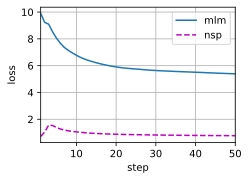

In [70]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

### Representing Text with BERT

- The following function returns the BERT (`net`) representations for all tokens in `tokens_a` and `tokens_b`.

In [71]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

- Consider the sentence “a crane is flying”.
- After inserting special tokens “\<cls\>” (used for classification) and “\<sep\>” (used for separation), the BERT input sequence has a length of six. 
- Since zero is the index of the “\<cls\>” token, `encoded_text[:, 0, :]` is the BERT representation of the entire input sentence. To evaluate the polysemy token “crane”, we also print out the first three elements of the BERT representation of the token.

In [72]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.8837,  1.0539, -0.8053], device='cuda:0', grad_fn=<SliceBackward0>))

- Now consider a sentence pair “a crane driver came” and “he just left”. Similarly, `encoded_pair[:, 0, :]` is the encoded result of the entire sentence pair from the pretrained BERT. 
- Note that the first three elements of the polysemy token “crane” are different from those when the context is different. This supports that BERT representations are **context-sensitive**.

In [73]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 0.6331,  0.7607, -0.7883], device='cuda:0', grad_fn=<SliceBackward0>))

## Sentiment Analysis: Using RNN

![nlp-map-sa-rnn.svg](./images/8/nlp-map-sa-rnn.svg)

- Like word similarity and analogy tasks, we can also apply pretrained word vectors to sentiment analysis.
- IMDb review dataset


In [74]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### Representing Single Text with RNNs

- In the following `BiRNN` class, while 
    - each token of a text sequence gets its individual pretrained GloVe representation via the embedding layer (`self.embedding`), 
    - the entire sequence is encoded by a bidirectional RNN (`self.encoder`). More concretely, the hidden states (at the last layer) of the bidirectional LSTM at both the initial and final time steps are concatenated as the representation of the text sequence. 
    - This single text representation is then transformed into output categories by a fully connected layer (`self.decoder`) with two outputs (“positive” and “negative”).

In [75]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [76]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

### Loading Pretrained Word Vectors

In [77]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [78]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [79]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

### Training and Evaluating the Model

loss 0.307, train acc 0.873, test acc 0.846
1802.1 examples/sec on [device(type='cuda', index=0)]


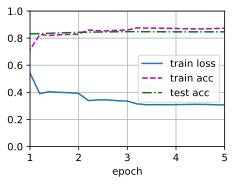

In [80]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [81]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [82]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [83]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Sentiment Analysis: Using CNN

![nlp-map-sa-cnn.svg](./images/8/nlp-map-sa-cnn.svg)

- Though originally designed for computer vision, CNNs are also widely used for natural language processing. Simply put, just think of any text sequence as a one-dimensional image. In this way, one-dimensional CNNs can process local features such as $n$-grams in text.


![conv1d-channel.svg](./images/8/conv1d-2d.svg)

- Two-dimensional cross-correlation operation with a single input channel. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation:

$$2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$$

- The *max-over-time pooling* used in textCNN works like the one-dimensional global max-pooling

In [84]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### The textCNN Model

![textcnn.svg](./images/8/textcnn.svg)

- For a single text sequence with $n$ tokens represented by $d$-dimensional vectors, the width, height, and number of channels of the input tensor are $n$, $1$, and $d$, respectively.
- The textCNN model transforms the input into the output as follows:

1. Define multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.
2. Perform max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.
3. Transform the concatenated vector into the output categories using the fully connected layer. Dropout can be used for reducing overfitting.


In [85]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

- Let’s create a textCNN instance. It has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.

In [86]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

### Loading Pretrained Word Vectors

In [87]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Training and Evaluating the Model

loss 0.065, train acc 0.979, test acc 0.869
4350.3 examples/sec on [device(type='cuda', index=0)]


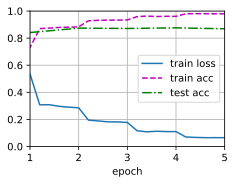

In [88]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [89]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [90]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Natural Language Inference

- *Natural language inference* studies whether a *hypothesis* can be inferred from a *premise*, where both are a text sequence. In other words, natural language inference determines the logical relationship between a pair of text sequences. Such relationships usually fall into three types:
    - Entailment: the hypothesis can be inferred from the premise.
    - Contradiction: the negation of the hypothesis can be inferred from the premise.
    - Neutral: all the other cases.
- Stanford Natural Language Inference (SNLI) Dataset

In [91]:
#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

- **Entailment**

> Premise: Two women are hugging each other. <br>
Hypothesis: Two women are showing affection.

- **Contradiction**

> Premise: A man is running the coding example from Dive into Deep Learning. <br>
Hypothesis: The man is sleeping.

- **Neutral**

> Premise: The musicians are performing for us.<br>
Hypothesis: The musicians are famous.

In [92]:
import re

#@save
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [93]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [94]:
# the three labels “entailment”, “contradiction”, and “neutral” 
# are balanced in both the training set and the testing set

test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


## Natural Language Inference: Using Attention

![nlp-map-nli-attention.svg](./images/8/nlp-map-nli-attention.svg)

- Parikh et al. (2016) proposed to address natural language inference with attention mechanisms and called it a “decomposable attention model”. 
- This results in a model without recurrent or convolutional layers, achieving the best result at the time on the SNLI dataset with much fewer parameters. 
- In this section, we will describe and implement this attention-based method (with MLPs) for natural language inference

[Parikh et al., 2016] Parikh, A. P., Täckström, O., Das, D., & Uszkoreit, J. (2016). A decomposable attention model for natural language inference. arXiv preprint arXiv:1606.01933.


###  The Model

![nli-attention.svg](./images/8/nli-attention.svg)

- We just align tokens in one text sequence to every token in the other, and vice versa, then compare and aggregate such information to predict the logical relationships between premises and hypotheses. 
- Similar to alignment of tokens between source and target sentences in machine translation, the alignment of tokens between premises and hypotheses can be neatly accomplished by attention mechanisms.


### Attending

- The first step is to align (softly) tokens in one text sequence to each token in the other sequence. Denote by $\mathbf{A} = (\mathbf{a}_1, \ldots, \mathbf{a}_m)$ and $\mathbf{B} = (\mathbf{b}_1, \ldots, \mathbf{b}_n)$ the premise and hypothesis, whose number of tokens are $m$ and $n$, respectively, where $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^{d}$ ($i = 1, \ldots, m, j = 1, \ldots, n$) is a $d$-dimensional word vector. For alignment, we compute the attention weights $e_{ij} \in \mathbb{R}$ as

$$e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j),$$

- where the function $f$ is an MLP defined in the following `mlp` function. The output dimension of $f$ is specified by the `num_hiddens` argument of `mlp`.


In [95]:
from torch.nn import functional as F

def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

- ormalizing the attention weights, we compute the weighted average of all the token vectors in the hypothesis to obtain representation of the hypothesis that is softly aligned with the token indexed by $i$ in the premise:

$$
\boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j.
$$

- Likewise, we compute soft alignment of premise tokens for each token indexed by $j$ in the hypothesis:

$$
\boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i.
$$

- Like the **Dynamic Programming** in Reinforcement Learning.
- Below we define the `Attend` class to compute the soft alignment of hypotheses (`beta`) with input premises `A` and soft alignment of premises (`alpha`) with input hypotheses `B`.

In [96]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

### Comparing

- In the comparing step, we feed the concatenation (operator $[\cdot, \cdot]$) of tokens from one sequence and aligned tokens from the other sequence into a function $g$ (an MLP):

$$\mathbf{v}_{A,i} = g([\mathbf{a}_i, \boldsymbol{\beta}_i]), i = 1, \ldots, m\\ \mathbf{v}_{B,j} = g([\mathbf{b}_j, \boldsymbol{\alpha}_j]), j = 1, \ldots, n.$$

- where $\mathbf{v}_{A,i}$ is the comparison between token $i$ in the premise and all the hypothesis tokens that are softly aligned with token $i$; while $\mathbf{v}_{B,j}$ is the comparison between token $j$ in the hypothesis and all the premise tokens that are softly aligned with token $j$.

In [97]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### Aggregating

- With two sets of comparison vectors $\mathbf{v}_{A,i}$ ($i = 1, \ldots, m$) and $\mathbf{v}_{B,j}$ ($j = 1, \ldots, n$) on hand, in the last step we will aggregate such information to infer the logical relationship. We begin by summing up both sets:

$$
\mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}.
$$

- Next we feed the concatenation of both summarization results into function $h$ (an MLP) to obtain the classification result of the logical relationship:

$$
\hat{\mathbf{y}} = h([\mathbf{v}_A, \mathbf{v}_B]).
$$

In [98]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

### Putting It All Together

In [99]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

### Training and Evaluating the Model

In [100]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [101]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [102]:
#@save
def split_batch_multi_inputs(X, y, devices):
    """Split multi-input `X` and `y` into multiple devices."""
    X = list(zip(*[gluon.utils.split_and_load(
        feature, devices, even_split=False) for feature in X]))
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

loss 0.493, train acc 0.806, test acc 0.821
21352.3 examples/sec on [device(type='cuda', index=0)]


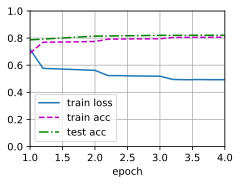

In [103]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [104]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [105]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## Natural Language Inference: Fine-Tuning BERT

![nlp-map-nli-bert.svg](./images/8/nlp-map-nli-bert.svg)

- Now we revisit this task by fine-tuning BERT, which *only* requires an additional MLP-based architecture.


In [2]:
import json
import multiprocessing

### Loading Pretrained BERT

In [3]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

- Either pretrained BERT model contains a “vocab.json” file that defines the vocabulary set and a “pretrained.params” file of the pretrained parameters. 
- We implement the following `load_pretrained_model` function to load pretrained BERT parameters.

In [4]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4,
        num_blks=2, dropout=0.2, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [5]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices)

/home/haodong/Applications/Miniconda/Miniconda/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### The Dataset

In [6]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [7]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

read 549367 examples
read 9824 examples


### Fine-Tuning BERT

- Fine-tuning BERT for natural language inference requires only an extra MLP consisting of two fully connected layers (see `self.hidden` and `self.output` in the following `BERTClassifier` class). 
- This MLP transforms the BERT representation of the special “\<cls\>” token, which encodes the information of both the premise and the hypothesis, into three outputs of natural language inference: entailment, contradiction, and neutral.

In [8]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

- In the following, the pretrained BERT model bert is fed into the `BERTClassifier` instance net for the downstream application. 
- In common implementations of BERT fine-tuning, only the parameters of the output layer of the additional MLP (`net.output`) will be learned from scratch. All the parameters of the pretrained BERT encoder (`net.encoder`) and the hidden layer of the additional MLP (`net.hidden`) will be fine-tuned.

In [9]:
net = BERTClassifier(bert)

- both the `MaskLM` class and the `NextSentencePred` class have parameters in their employed MLPs.
- These parameters are part of those in the pretrained BERT model `bert`, and thus part of parameters in `net`.
- However, these two parts are irrelevant to fine-tuning downstream applications, thus the parameters of the employed MLPs in `MaskLM` and `NextSentencePred` are not updated (staled) when BERT is fine-tuned.

loss 0.423, train acc 0.834, test acc 0.794
3136.9 examples/sec on [device(type='cuda', index=0)]


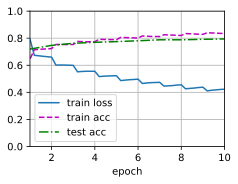

In [10]:
lr, num_epochs = 1e-4, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [21]:
def predict_snli_bert(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    tokens_X = [vocab.token_to_idx['<cls>']] + \
        [vocab.token_to_idx[item] for item in premise] + [vocab.token_to_idx['<sep>']] + \
        [vocab.token_to_idx[item] for item in hypothesis] + [vocab.token_to_idx['<sep>']]
    segments_X = [0] + [0 for item in premise] + [0] + [1 for item in hypothesis] + [1]
    valid_lens_x = len(tokens_X)
    
    for i in range(128):
        if i < valid_lens_x:
            continue
        else:
            tokens_X.append(1)
            segments_X.append(0)

    tokens_X = torch.tensor(tokens_X, device=d2l.try_gpu()).reshape((1, -1))
    segments_X = torch.tensor(segments_X, device=d2l.try_gpu()).reshape((1, -1))
    valid_lens_x = torch.tensor([valid_lens_x], device=d2l.try_gpu())
    
    result = net([tokens_X, segments_X, valid_lens_x])
    print(result[0])
    label = torch.argmax(result, dim=1)[0]
    return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [37]:
predict_snli_bert(net, vocab, ['he', 'is', 'delighted', '.'], ['he', 'feels', 'good', '.'])

tensor([0.4168, 0.0197, 0.2690], device='cuda:0', grad_fn=<SelectBackward0>)


'entailment'

In [36]:
predict_snli_bert(net, vocab, ['he', 'is', 'depressed', '.'], ['he', 'is', 'tall', '.'])

tensor([-2.2405, -0.3519,  2.2688], device='cuda:0', grad_fn=<SelectBackward0>)


'neutral'

In [24]:
predict_snli_bert(net, vocab, ['he', 'is', 'so', 'thin', '.'], ['he', 'eats', 'a', 'lot', '.'])

tensor([-3.1151,  3.7257, -0.1885], device='cuda:0', grad_fn=<SelectBackward0>)


'contradiction'

## Chat with ChatGPT

[https://lebronlihd.github.io/blog/2023/chat-with-chatgpt/](https://lebronlihd.github.io/blog/2023/chat-with-chatgpt/)

In [116]:
!pip install openai # !conda install -c conda-forge openai

In [117]:
# export OPENAI_API_KEY='sk-...'
import openai

messages = [] # [{"role": "system", "content": "You are a strict interviewer"}]
user_text = input("You: ")

def no_br_in_begin(reply):
    for i in range(len(reply)):
        if reply[i] != '\n':
            return reply[i:]
    raise KeyboardInterrupt

def interact_with_ChatGPT():
    global messages, user_text

    # I want this code to run indefinitely, until any of the parties say Thank You
    while user_text not in ["q", "Q"]:
        messages.append({"role": "user", "content": user_text})
        # Now gpt-4 is availavle for ChatGPT-Plus, New Bing, or Dev. API
        response = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages)
        reply = response.choices[0].message.content
        print("\nChatGPT:", no_br_in_begin(reply))
        messages.append({"role": "assistant", "content": reply})
        user_text = input("\nYou: ")

interact_with_ChatGPT()

You: Hi, what is the main idea about AlphaFold2?

ChatGPT: AlphaFold2 is a revolutionary artificial intelligence system that can predict the 3D structure of proteins with remarkable accuracy. It has the potential to transform the field of protein science and could lead to major breakthroughs in drug development, disease understanding, and personalized medicine. The system was developed by researchers at the University of California, San Francisco (UCSF) and the University of Washington, and was recently recognized as a breakthrough achievement in artificial intelligence, winning the prestigious Casp14 protein-structure prediction competition.

You: Will it replace protein scientists in the future?

ChatGPT: No, it is not likely that AlphaFold2 will completely replace protein scientists in the future. While AlphaFold2 is certainly a powerful tool that can greatly aid in protein research, there are still areas where human expertise is required. For example, AlphaFold2 currently requires 

### GPT-3.5 v.s. GPT-4

![gpt-3.5-vs-4.png](./images/8/gpt-3.5-vs-4.png)

In [119]:
# Written by ChatGPT on 03/20/2023
import openai
import requests
from PIL import Image

# Define the text prompt for the image
text = input('You: ')

# Call the OpenAI DALL-E2 API to generate the image
response = openai.Image.create(
    prompt=text,
    size='512x512',
    model='image-alpha-001'
)

# Get the image data from the API response
url = response['data'][0]['url']
image_data = requests.get(url).content

# Save the image to a file
image_path = './images/8/' + text.replace(' ', '_') + '.png'
print('Generated image was saved at ->', image_path)
with open(image_path, 'wb') as f:
    f.write(image_data)

# Load the image to a PIL Image object and display it
image = Image.open(image_path)
image.show()

You: Two dogs eating pizza, in realistic style
Generated image was saved at -> ./images/8/Two_dogs_eating_pizza,_in_realistic_style.png


![png](./images/8/Two_dogs_eating_pizza,_in_realistic_style.png)

## nanoGPT

- The simplest, fastest repository for training/finetuning medium-sized GPTs
- [https://github.com/karpathy/nanoGPT](https://github.com/karpathy/nanoGPT)
- by: [Andrej Karpathy](https://karpathy.ai/)

```
ANGELO:
And cowards it be strawn to my bed,
And thrust the gates of my threats,
Because he that ale away, and hang'd
An one with him.

DUKE VINCENTIO:
I thank your eyes against it.

DUKE VINCENTIO:
Then will answer him to save the malm:
And what have you tyrannous shall do this?

DUKE VINCENTIO:
If you have done evils of all disposition
To end his power, the day of thrust for a common men
That I leave, to fight with over-liking
Hasting in a roseman.
```